enlace de data set:https://drive.google.com/drive/u/1/folders/1G3ZumR0DDARyRQL4JadeCwvCOIZBDKSr

In [ ]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp -av "/content/drive/MyDrive/dataset_basura_deteccion" "/content/data"

'/content/drive/MyDrive/dataset_basura_deteccion' -> '/content/data'


In [ ]:
import json
cocofile= open("/content/data/labels/bolsasPlasticas/polygon/labels_bolsasPlaticas_coco_format.json")
cartones_coco = json.load(cocofile)

In [ ]:
cartones_coco['categories'][0],cartones_coco['images'][0], cartones_coco['annotations'][0]

({'id': 1, 'name': 'bolsaPlastica'},
 {'file_name': 'bolsa (1000).png', 'height': 600, 'id': 1, 'width': 800},
 {'area': 159351.90261135908,
  'bbox': [173.4513274336283,
   74.63126843657817,
   451.91740412979357,
   525.3687315634219],
  'category_id': 1,
  'id': 0,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [[173.4513274336283,
    212.6843657817109,
    233.6283185840708,
    167.8466076696165,
    323.3038348082596,
    79.35103244837758,
    343.36283185840705,
    74.63126843657817,
    442.4778761061947,
    159.58702064896755,
    625.3687315634219,
    229.20353982300884,
    625.3687315634219,
    535.9882005899705,
    580.5309734513274,
    599.7050147492625,
    525.0737463126843,
    600,
    471.976401179941,
    579.6460176991151,
    385.8407079646018,
    537.1681415929204,
    303.2448377581121,
    458.1120943952802,
    173.4513274336283,
    333.03834808259586]]})

In [ ]:
image_id=1
coco_data=COCO("/content/data/labels/bolsasPlasticas/polygon/labels_bolsasPlaticas_coco_format.json")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
img = coco_data.imgs[image_id]
img

{'file_name': 'bolsa (1000).png', 'height': 600, 'id': 1, 'width': 800}

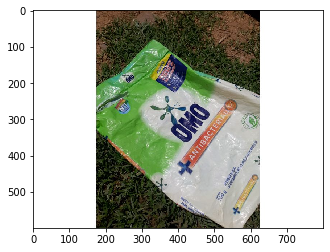

In [ ]:
image = np.array(Image.open("/content/data/images/bolsasPlasticas/"+img['file_name']).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

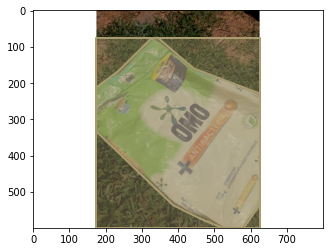

In [ ]:
plt.imshow(image)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

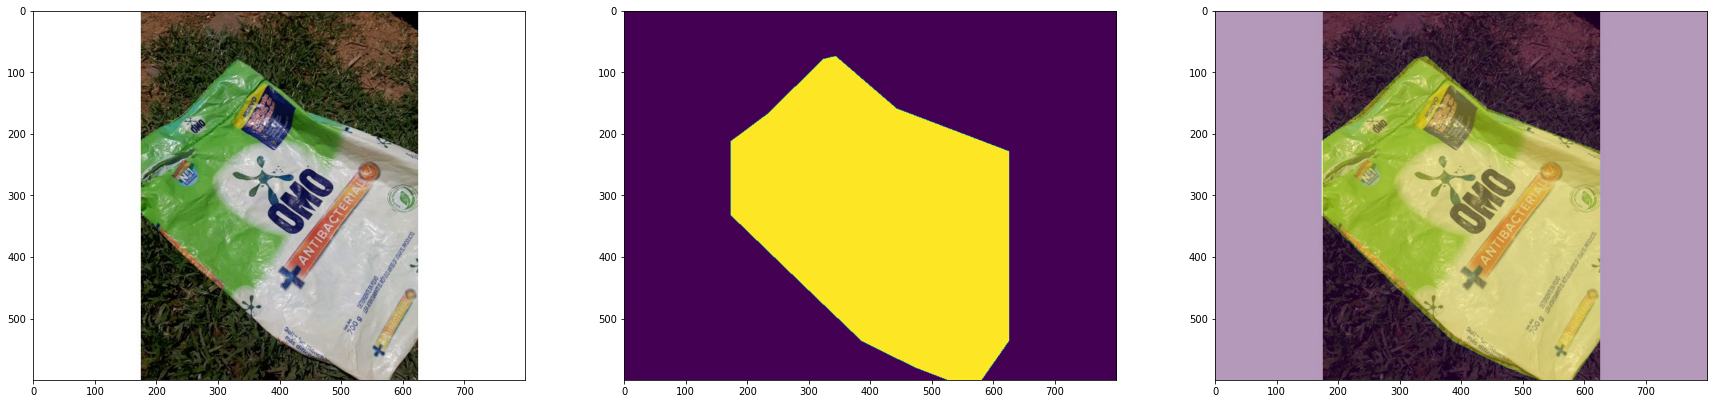

In [ ]:
mask = coco_data.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(image)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [ ]:
image.shape

(600, 800, 3)

In [ ]:
mask = coco_data.annToMask(anns[0])
mask.shape, image.max()

((600, 800), 255)

In [ ]:
from random import sample
def loadImages(dataset_coco, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    test_ids = sample([x for x in range(0,len(coco_data.anns))],int(len(coco_data.anns)*split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        img_ = coco_data.imgs[image_id_]
        image_path="/content/data/images/bolsasPlasticas/"+img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_)/255
        anns_=dataset_coco.loadAnns(data_[i]['id'])
        mask_ = dataset_coco.annToMask(anns_[0])
        for ian in range(len(anns_)):
            mask_ += dataset_coco.annToMask(anns_[ian])
        if(i not in test_ids):
            img_train_.append(image_path)
            labels_train_.append(mask_)
        else:
            img_test_.append(image_path)
            labels_test_.append(mask_)
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [ ]:
img_train, img_test, labels_train, labels_test = loadImages(coco_data, split=0.1)

In [ ]:
labels_train.shape, labels_test.shape, labels_test.min(), labels_test.max()

((801, 600, 800), (89, 600, 800), 0, 2)

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
      image_load = Image.open(self.X[ix]).convert('RGB')
      image = np.array(image_load)/255
      img = image
      img = image.astype(np.float32)

      mask = self.y[ix]    
      img = torch.from_numpy(img).permute(2,0,1)
      mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
      return img, torch.from_numpy(mask).permute(2,0,1)

In [ ]:
dataset = {
    'train': Dataset(img_train, labels_train),
    'test': Dataset(img_test, labels_test)
}

len(dataset['train']), len(dataset['test'])

(801, 89)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 600, 800]), torch.Size([5, 3, 600, 800]))

In [ ]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet()
output = model(torch.randn((5,3,600,800)))
output.shape

torch.Size([5, 3, 600, 800])

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.17113 test_iou 0.93827: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]



Epoch 1/30 loss 0.33679 iou 0.71848 test_loss 0.17113 test_iou 0.93827


test_loss 0.15543 test_iou 0.93646: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]



Epoch 2/30 loss 0.19193 iou 0.92409 test_loss 0.15543 test_iou 0.93646


test_loss 0.08872 test_iou 0.96351: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]



Epoch 3/30 loss 0.15607 iou 0.93125 test_loss 0.08872 test_iou 0.96351


test_loss 0.09111 test_iou 0.96195: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]



Epoch 4/30 loss 0.13664 iou 0.93770 test_loss 0.09111 test_iou 0.96195


test_loss 0.08844 test_iou 0.96123: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]



Epoch 5/30 loss 0.11154 iou 0.94803 test_loss 0.08844 test_iou 0.96123


test_loss 0.08424 test_iou 0.96638: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]



Epoch 6/30 loss 0.10313 iou 0.95148 test_loss 0.08424 test_iou 0.96638


test_loss 0.09120 test_iou 0.96863: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]



Epoch 7/30 loss 0.09977 iou 0.95186 test_loss 0.09120 test_iou 0.96863


test_loss 0.06208 test_iou 0.96813: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]



Epoch 8/30 loss 0.10012 iou 0.95298 test_loss 0.06208 test_iou 0.96813


test_loss 0.05202 test_iou 0.97426: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]



Epoch 9/30 loss 0.08072 iou 0.96044 test_loss 0.05202 test_iou 0.97426


test_loss 0.05366 test_iou 0.97388: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]



Epoch 10/30 loss 0.07611 iou 0.96155 test_loss 0.05366 test_iou 0.97388


test_loss 0.04524 test_iou 0.97671: 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]



Epoch 11/30 loss 0.06739 iou 0.96584 test_loss 0.04524 test_iou 0.97671


test_loss 0.04169 test_iou 0.97621: 100%|██████████| 9/9 [00:05<00:00,  1.61it/s]



Epoch 12/30 loss 0.06153 iou 0.96803 test_loss 0.04169 test_iou 0.97621


test_loss 0.05005 test_iou 0.97275: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]



Epoch 13/30 loss 0.05906 iou 0.96916 test_loss 0.05005 test_iou 0.97275


test_loss 0.04508 test_iou 0.97711: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]



Epoch 14/30 loss 0.05765 iou 0.96962 test_loss 0.04508 test_iou 0.97711


test_loss 0.03541 test_iou 0.97986: 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]



Epoch 15/30 loss 0.05370 iou 0.97125 test_loss 0.03541 test_iou 0.97986


test_loss 0.03826 test_iou 0.97860: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]



Epoch 16/30 loss 0.05198 iou 0.97243 test_loss 0.03826 test_iou 0.97860


test_loss 0.04810 test_iou 0.97661: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]



Epoch 17/30 loss 0.04940 iou 0.97345 test_loss 0.04810 test_iou 0.97661


test_loss 0.04336 test_iou 0.97604: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]



Epoch 18/30 loss 0.05240 iou 0.97208 test_loss 0.04336 test_iou 0.97604


test_loss 0.03394 test_iou 0.98106: 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]



Epoch 19/30 loss 0.04908 iou 0.97378 test_loss 0.03394 test_iou 0.98106


test_loss 0.03530 test_iou 0.98121: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]



Epoch 20/30 loss 0.05551 iou 0.97078 test_loss 0.03530 test_iou 0.98121


loss 0.02962 iou 0.99192:   1%|          | 1/161 [00:00<01:26,  1.86it/s]

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=5)

test_loss 0.21038 test_iou 0.92447: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]



Epoch 1/5 loss 0.41091 iou 0.62971 test_loss 0.21038 test_iou 0.92447


test_loss 0.21156 test_iou 0.90914: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]



Epoch 2/5 loss 0.21332 iou 0.92291 test_loss 0.21156 test_iou 0.90914


test_loss 0.24866 test_iou 0.85589: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]



Epoch 3/5 loss 0.16480 iou 0.93346 test_loss 0.24866 test_iou 0.85589


test_loss 0.21956 test_iou 0.92122: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]



Epoch 4/5 loss 0.13743 iou 0.93924 test_loss 0.21956 test_iou 0.92122


test_loss 0.13265 test_iou 0.93469: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 5/5 loss 0.12015 iou 0.94552 test_loss 0.13265 test_iou 0.93469


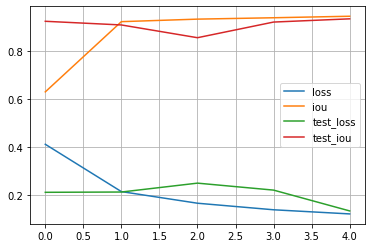

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

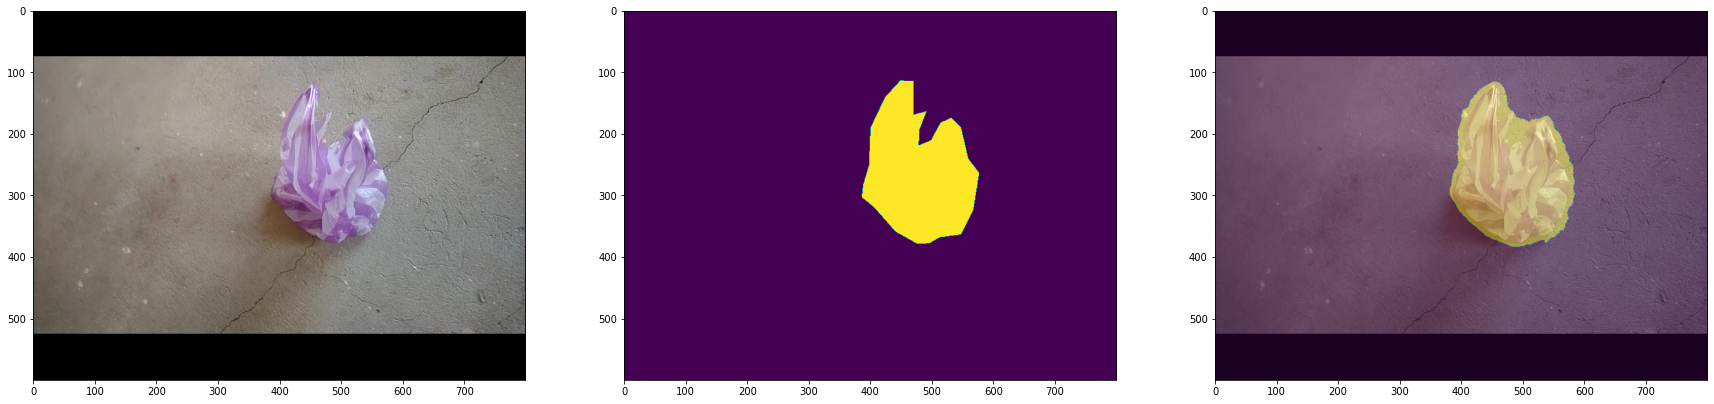

In [ ]:
model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    #output = model(img.to(device))[0]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
#ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.imshow(img.squeeze(0).permute(1,2,0))
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.4)

TRANSFER LEARNIG

In [ ]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [ ]:
model = UNetResnet()
output = model(torch.randn((1,3,394,394)))
output.shape

In [ ]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

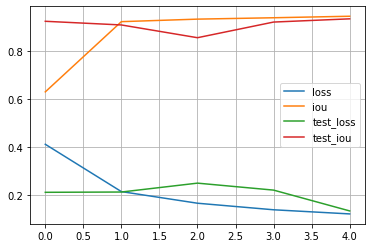

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

TypeError: ignored

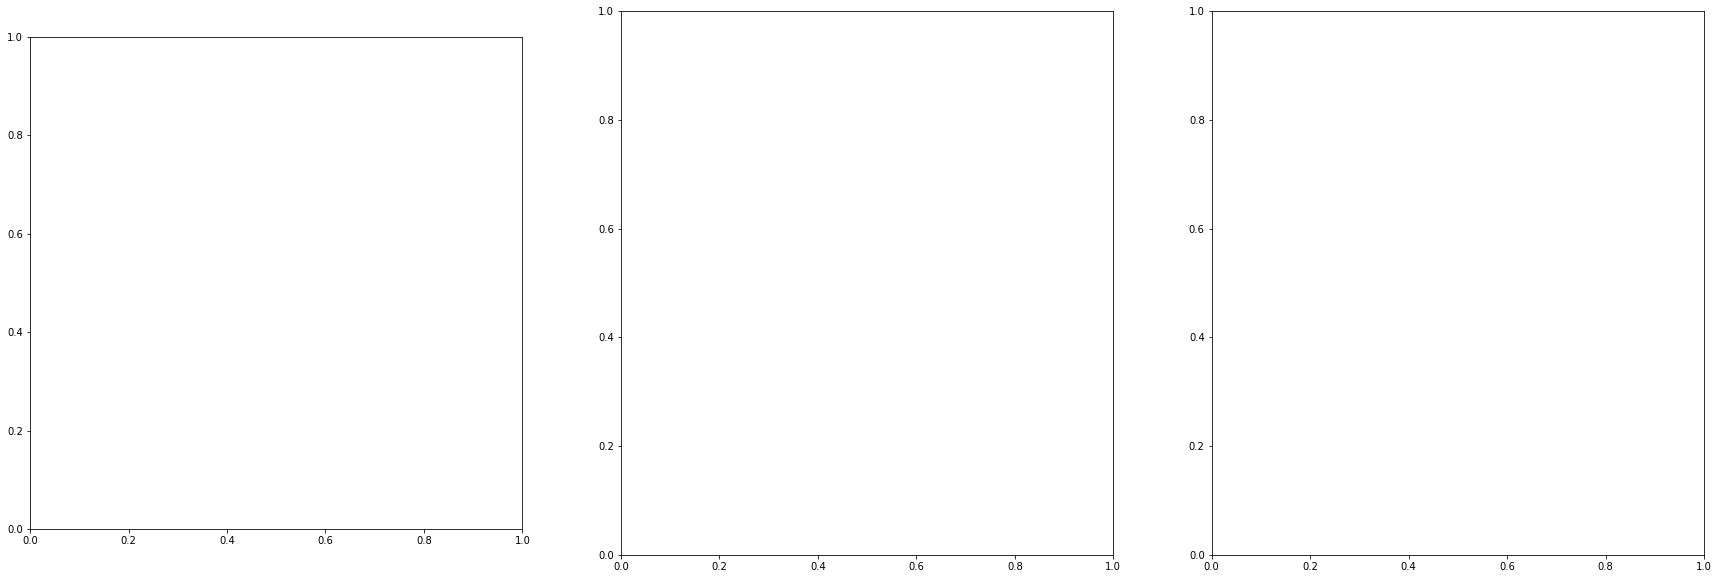

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()